In [1]:
import shutil, os
import matplotlib.pyplot as plt
import numpy as np
import detectron2
from detectron2.data import DatasetCatalog,MetadataCatalog
from plain_train_net import grab_dataset

reprocess_results=False
dataset_name = "val"
dpi=120

In [2]:
#predict
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file('configs/working.yaml')
#really low iou for nms in order to separate out lesions
# cfg.merge_from_list(["MODEL.WEIGHTS", "output_valid_"+ dataset_name + "/model_final.pth",
                    #  "OUTPUT_DIR", "output_valid_"+ dataset_name + "/results"])
cfg.merge_from_list(["OUTPUT_DIR", "output_"+ dataset_name])
#print(cfg.dump())  # print formatted configs
print(cfg.MODEL.ROI_HEADS.dump())
print(cfg.MODEL.WEIGHTS)
print(cfg.OUTPUT_DIR)


BATCH_SIZE_PER_IMAGE: 512
IN_FEATURES:
- p2
- p3
- p4
- p5
IOU_LABELS:
- 0
- 1
IOU_THRESHOLDS:
- 0.5
NAME: StandardROIHeads
NMS_THRESH_TEST: 0.01
NUM_CLASSES: 1
POSITIVE_FRACTION: 0.25
PROPOSAL_APPEND_GT: true
SCORE_THRESH_TEST: 0.001

detectron2://ImageNetPretrained/FAIR/X-101-32x8d.pkl
output_val


In [3]:
for name in [dataset_name]:
    try:
        DatasetCatalog.register(name, grab_dataset(name))
    except:
        print('Already registered.')
        #do nothing
    MetadataCatalog.get(name).thing_classes = ["rpd"]

In [4]:
if reprocess_results:
    #build model
    from detectron2.modeling import build_model
    model = build_model(cfg)  # returns a torch.nn.Module
    from detectron2.checkpoint import DetectionCheckpointer
    DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS);  # load a file, usually from cfg.MODEL.WEIGHTS
    model.eval(); #set model in evaluation mode

    from detectron2.data import build_detection_test_loader
    myloader = build_detection_test_loader(cfg,dataset_name)

    from plain_train_net import EvaluateClass
    myeval = EvaluateClass(
        dataset_name, cfg.OUTPUT_DIR,iou_thresh = .2,prob_thresh=0.5)
    from detectron2.evaluation import inference_on_dataset
    results_i = inference_on_dataset(model, myloader, myeval)
else:
    from plain_train_net import EvaluateClass
    myeval = EvaluateClass(
        dataset_name, cfg.OUTPUT_DIR,iou_thresh = .2,prob_thresh=0.5,evalsuper=False)
    myeval.evaluate()

%precision 3
# import json
# with open(os.path.join(cfg.OUTPUT_DIR,'scalar_dict_'+dataset_name+'.json'),"w") as outfile:
#     json.dump(myeval.summarize_scalars(),outfile)

myeval.summarize_scalars()

Using previously cached COCO format annotations at 'output_val/val_coco_format.json'. You need to clear the cache file if your dataset has been modified.


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.15s)
creating index...
index created!
Calculated metrics for 931 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.36s).
Accumulating evaluation results...
DONE (t=0.02s).


{'dataset': 'val',
 'precision': 0.503,
 'recall': 0.830,
 'fpr': 0.321,
 'iou': 0.200,
 'probability': 0.500}

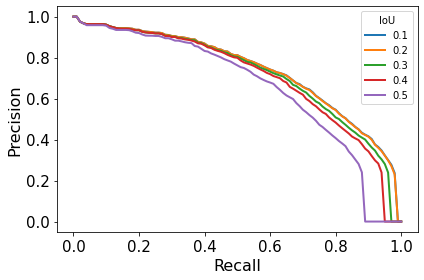

In [5]:
myeval.plot_PRcurve()
plt.tight_layout()
plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'PRCurve_'+dataset_name+'.png'),dpi=dpi)


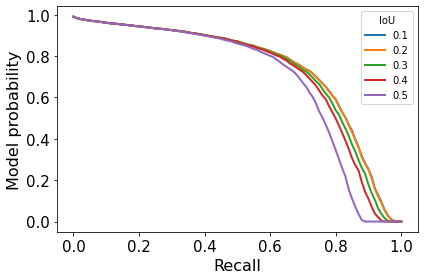

In [6]:
myeval.plot_recall_vs_prob()
plt.tight_layout()
plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'ProbvsRecall_'+dataset_name+'.png'),dpi=dpi)

In [5]:

from plain_train_net import CreatePlotsRPD
RPDplt = CreatePlotsRPD.initfromcoco(myeval.mycoco,myeval.prob_thresh)

In [8]:
RPDplt.dfimg.to_csv(os.path.join(cfg.OUTPUT_DIR,'dfimg_'+dataset_name+'.csv'))
RPDplt.dfpts.to_csv(os.path.join(cfg.OUTPUT_DIR,'dfpts_'+dataset_name+'.csv'))

[0.892 0.976 0.937 0.962 0.884 0.811] [0.761 0.713 0.686 0.667 0.745 0.789] [0.012 0.002 0.003 0.001 0.004 0.005]


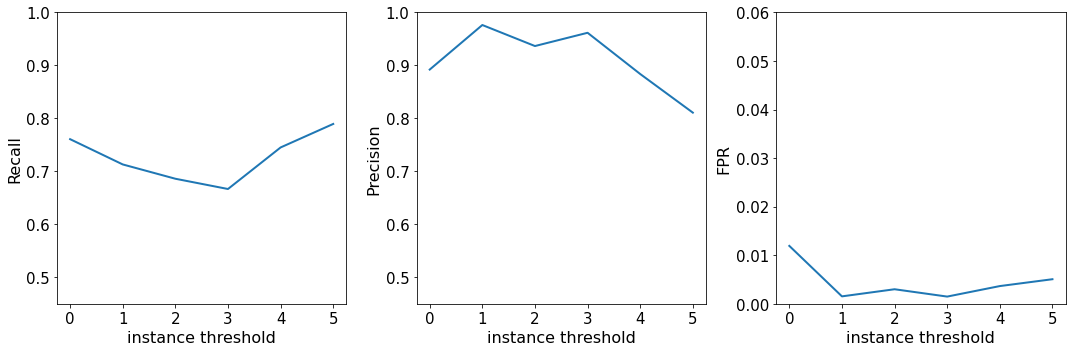

In [6]:
inst = list(range(0,6))
#inst = [4]
pr,rc,fpr = RPDplt.plot_img_level_instance_thresholding(RPDplt.dfimg,inst)
plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'instance_thresh_scan_level_'+dataset_name+'.png'),dpi=dpi)
print(pr,rc,fpr)

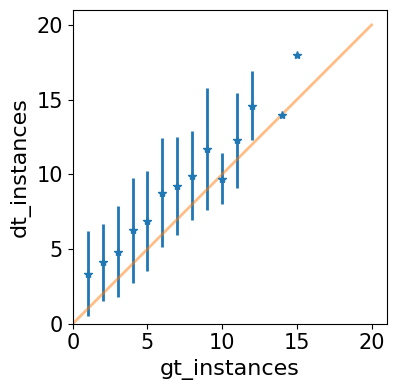

In [6]:
fig = RPDplt.gt_vs_dt_instances()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_instances_'+dataset_name+'.png'),dpi=dpi)

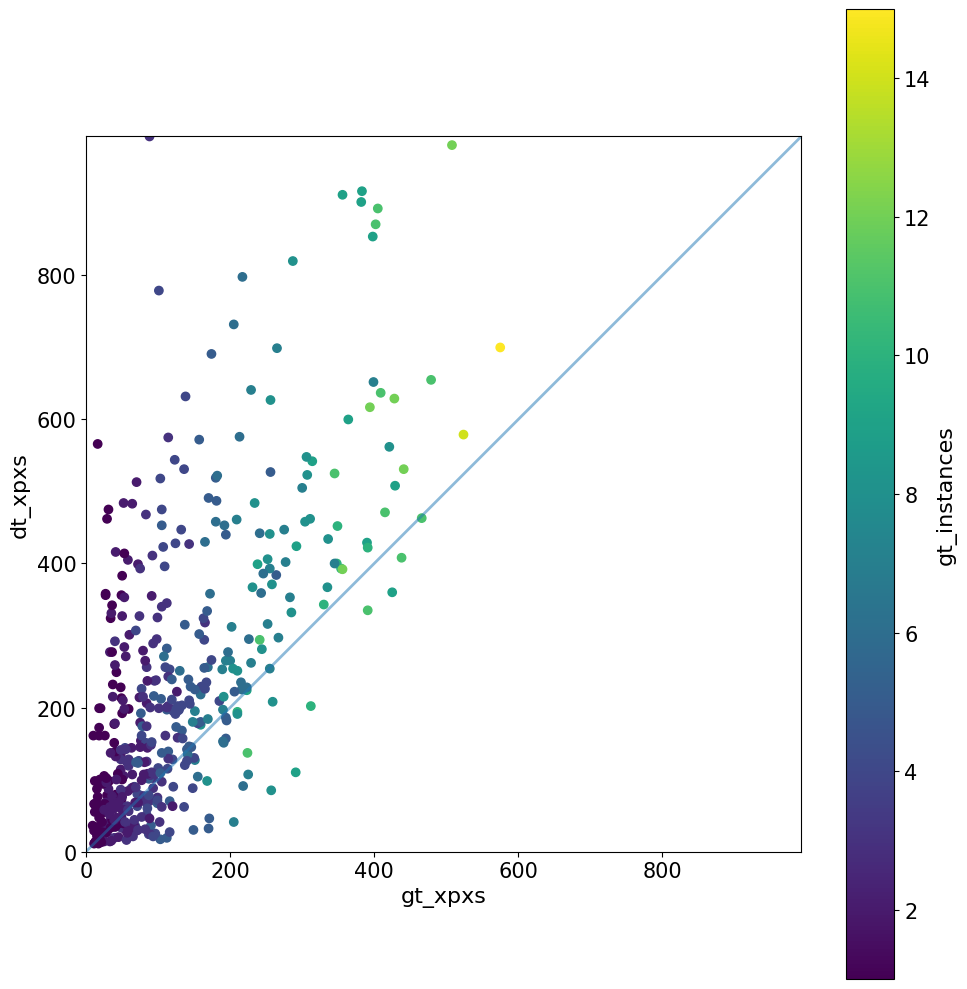

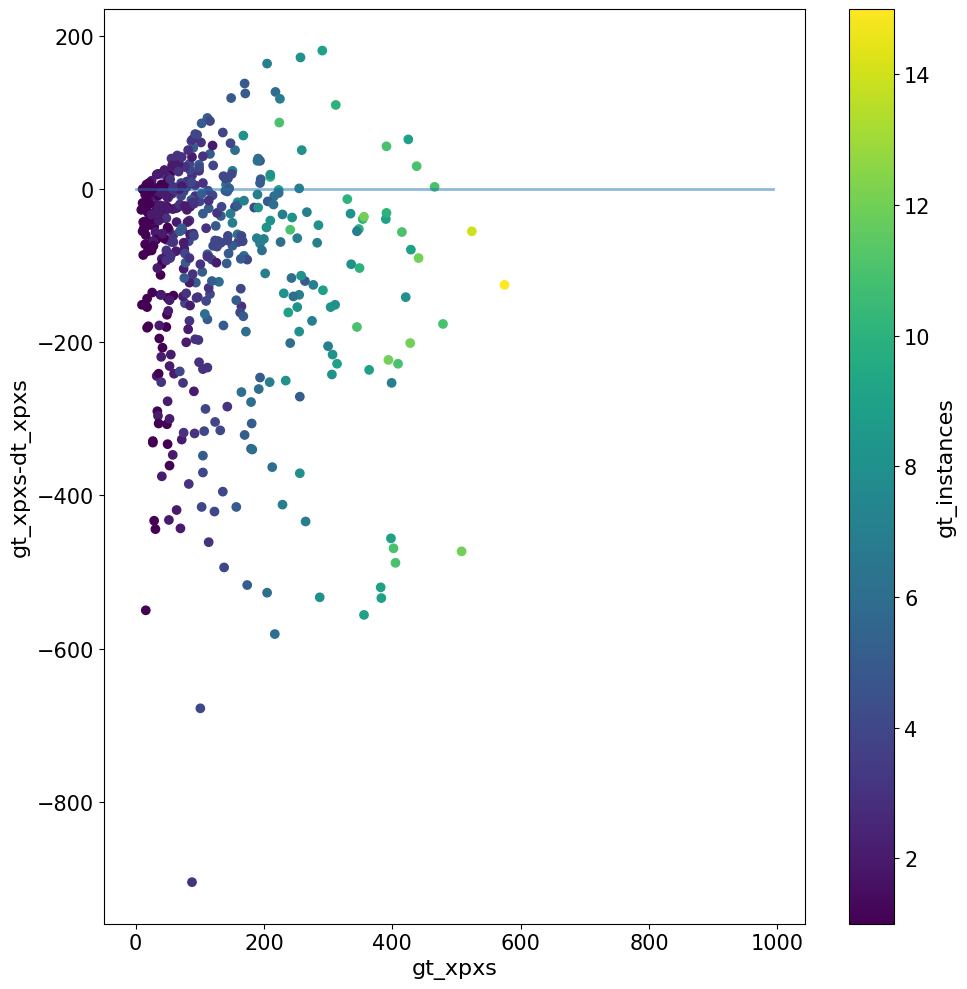

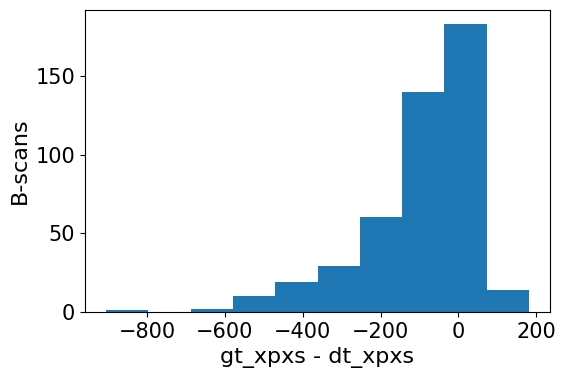

In [7]:
fig1,fig2,fig3 = RPDplt.gt_vs_dt_xpxs()
fig1.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_xpxs_'+dataset_name+'.png'),dpi=dpi)
fig2.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_del_xpxs_'+dataset_name+'.png'),dpi=dpi)

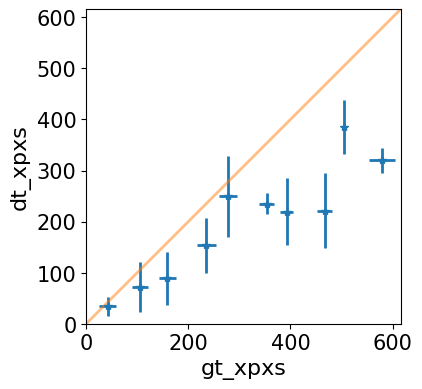

In [12]:
fig = RPDplt.gt_vs_dt_xpxs_mu()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_mu_xpxs_'+dataset_name+'.png'),dpi=dpi)

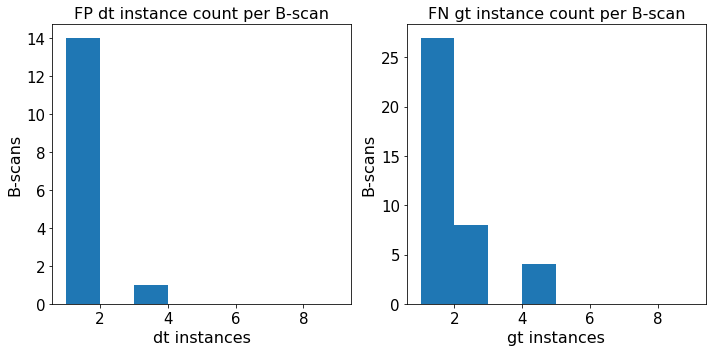

In [13]:
fig = RPDplt.gt_dt_FP_FN_count()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_FP_FN_count_'+dataset_name+'.png'),dpi=dpi)

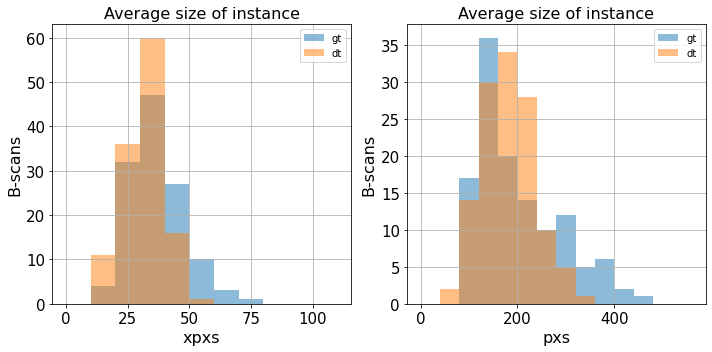

In [14]:
fig = RPDplt.avg_inst_size()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'avg_inst_size_'+dataset_name+'.png'),dpi=dpi)

In [15]:
RPDplt.dfimg

,gt_instances,gt_pxs,gt_xpxs,dt_instances,dt_pxs,dt_xpxs,ptid,eye,scan
102044_OD_oct-012.png,4.0,1078.0,176.0,1.0,254.0,35.0,102044,OD,oct-012
101257_OS_oct-020.png,0.0,0.0,0.0,0.0,0.0,0.0,101257,OS,oct-020
101029_OD_oct-025.png,0.0,0.0,0.0,0.0,0.0,0.0,101029,OD,oct-025
105012_OD_oct-027.png,0.0,0.0,0.0,0.0,0.0,0.0,105012,OD,oct-027
102040_OD_oct-025.png,0.0,0.0,0.0,0.0,0.0,0.0,102040,OD,oct-025
...,...,...,...,...,...,...,...,...,...
101056_OS_oct-044.png,0.0,0.0,0.0,0.0,0.0,0.0,101056,OS,oct-044
102040_OD_oct-014.png,0.0,0.0,0.0,0.0,0.0,0.0,102040,OD,oct-014
102001_OS_oct-042.png,0.0,0.0,0.0,0.0,0.0,0.0,102001,OS,oct-042
101068_OS_oct-042.png,0.0,0.0,0.0,0.0,0.0,0.0,101068,OS,oct-042


In [16]:
#df = RPDplt.dfimg
#from plain_train_net import OutputVis
#vis = OutputVis(dataset_name,cfg,0.5)
#ImgIds = np.abs(df.gt_xpxs-df.dt_xpxs).sort_values(ascending=False).index[0:50].values
#vis.output_to_pdf(ImgIds,os.path.join(cfg.OUTPUT_DIR,'top50_xpxs_err_'+dataset_name+'.pdf'),dfimg =myeval.dfimg )

In [37]:
dfpts = RPDplt.dfpts
import pandas as pd
pd.set_option('display.max_rows',500)
#df_ext = pd.read_csv('/data/amd-data/cera-rpd/RPD_Himeesh_val_extracted/dataframe.csv')
#len(df_ext.groupby(['ptid','eye'])[['ptid','eye']].size())
flist = []
for f in next(os.walk('/data/amd-data/cera-rpd/RPD_Himeesh_val/'))[2]:
    if f.endswith('.vol'):
        flist.append(f.rstrip('.vol').split('_')) 
dfext = pd.DataFrame(flist,columns=['ptid','eye']).set_index(['ptid','eye'])
dfext[~dfext.index.isin(dfpts.index)].index


MultiIndex([('101109', 'OS'),
            ('101334', 'OS'),
            ('101260', 'OS'),
            ('101106', 'OD'),
            ('101217', 'OD')],
           names=['ptid', 'eye'])

Precision = [0.636 0.778 1.    1.    1.    1.   ]
 Recall = [1. 1. 1. 1. 1. 1.]
 FPR = [0.182 0.091 0.    0.    0.    0.   ]



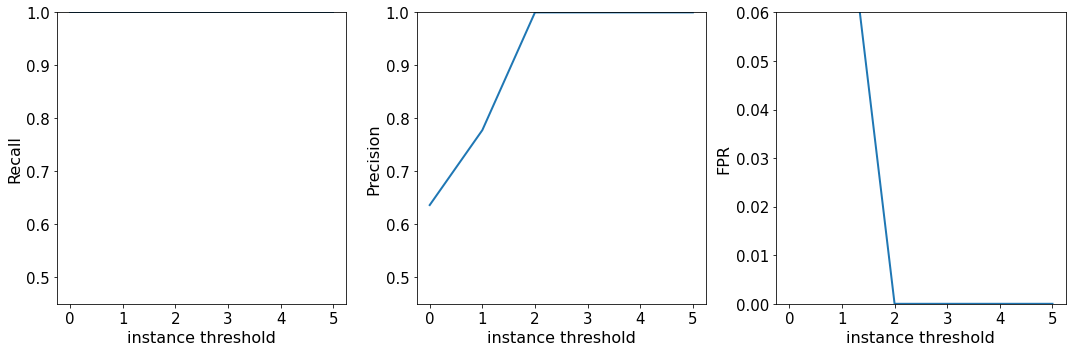

In [9]:
inst = list(range(0,6))
pr,rc,fpr = RPDplt.plot_img_level_instance_thresholding(RPDplt.dfpts,inst)
print('Precision = {}\n Recall = {}\n FPR = {}\n'.format(pr,rc,fpr))

In [5]:
def hover(hover_color="#add8e6"):
    return dict(selector="tbody tr:hover",
            props=[("background-color", "%s" % hover_color)])

styles = [
    #table properties
    dict(selector=" ", 
         props=[("margin","0"),
                ("font-family",'"Helvetica", "Arial", sans-serif'),
                ("border-collapse", "collapse"),
                ("border","none"),
                ("border", "2px solid #ccf")
                   ]),

#     #header color - optional
#     dict(selector="thead", 
#          props=[("background-color","#cc8484")
#                ]),

    #background shading
    dict(selector="tbody tr:nth-child(even)",
         props=[("background-color", "#fff")]),
    dict(selector="tbody tr:nth-child(odd)",
         props=[("background-color", "#eee")]),

    #cell spacing
    dict(selector="td", 
         props=[("padding", ".5em"),("text-align","center")]),

    #header cell properties
    dict(selector="th", 
         props=[("font-size", "125%"),
                ("text-align", "center")]),

    #caption placement
    dict(selector="caption", 
         props=[("caption-side", "bottom")]),

    #render hover last to override background-color
    hover()
]


In [20]:
html_str = dfpts.style.format('{:.0f}').set_table_styles(styles).render()
html_file = open(os.path.join(cfg.OUTPUT_DIR,'dfpts_'+dataset_name+'.html'),'w')
html_file.write(html_str)
html_file.close()

In [21]:
dfpts.style.format('{:.0f}').set_table_styles(styles).set_table_attributes('style="font-size: 17px"')

In [17]:
import json, os
import pandas as pd
mydicts=[]
for name in ['fold1','fold2','fold3','fold4','fold5']:
    with open(os.path.join('output_valid_'+name,'results','scalar_dict_'+name+'.json')) as f:
        mydicts.append(json.load(f))
dfr = pd.DataFrame(mydicts)
pd.set_option('display.precision',2)
dfr.style.set_table_styles(styles).set_table_attributes('style="font-size: 17px"')

,dataset,precision,recall,fpr,iou,probability
0,fold1,0.84,0.78,0.05,0.20,0.50
1,fold2,0.64,0.77,0.03,0.20,0.50
2,fold3,0.85,0.62,0.01,0.20,0.50
3,fold4,0.63,0.75,0.03,0.20,0.50
4,fold5,0.55,0.82,0.04,0.20,0.50
